# Tutorial for utilizing QSOP codebase 
This notebook will demonstrate how to use the classes and functions in the QSOP directory. Specifically, how to:  
1. Retrieve included .g6 files of varying order graphs and convert them to networkx graph structures 

2. Specify which graph problem is to be analyzed in a given run

3. Convert the graph structure to a Boolean instance of the desired graph problem 

4. Convert the Boolean instance into an equal but reconstructed Exclusive Sum of Products (ESOP) form.

5. Construct a quantum oracle from the ESOP expansion. 

As well as some other pertinent details, such as: 
- The structure of the codebase 
- Necessary machine configuration for use 
- Current status of operation/improvement


## The Structure of the Codebase
The directory has several important files and folders, which I will detail here: 

**FOLDERS**: 

*<u>xgraphFiles</u>*: This folder contains 7 .g6 files, named "graph(n)c.g6", where (n) is the order of the graphs in that file ranging from 3 to 9. Each line in the file represents a unique connected graph of (n) nodes. 
For example, graph3c.g6 has two lines for the only two graphs of 3 nodes, while graph6c.g6 has information for 112, 6-node graphs. 

*<u>ESOPsimple</u>*: This folder contains the dependencies and necessary overhead for running the easy.c++ code that is detailed later in this notebook. 
Most imortantly, this folder contains *esopTest.cpp* and *between.txt*, which are the key files in using the easy.c++ to convert Boolean Instances to ESOPs. 

**FILES**: 

*<u>oracle.py</u>*: This is arguably the most important file for the first half of the pipeline. It contains *GraphGenerator* and *BooleanInstance* classes which will be detailed on later. 

*<u>sympy_esop_to_qcirc_t.py</u>*: Contains class *ESOPQuantumCircuit* for converting the ESOPs into quantum oracles. 

*<u>oracle_and_gm_qaoa.py</u>*: Contains classes *StatePrep* and *GMQAOA* for constructing full quantum circuits for GM-QAOA around the oracles produced from the previous class, as well as for running them. 

*<u>full_pipeline.py</u>* : a file that implements the whole pipeline from graph to Quantum Circuit, and is set up for analysis of *entire groups* of k-node graphs. 


## NECESSARY NON-NATIVE PYTHON AND C++ LIBRARIES: 

PYTHON:  
- sympy 
- networkx
- matplotlib
- qiskit 

C++: 
- g++ compiler with QSOP directory in PATH for compilation
- native g++ library files (vector, fstream...) 




# TUTORIAL ON USING QSOP 

Firstly, we need to grab a graph (or many graphs) from the .g6 files in the directory. 
We can do this by creating a *GraphGenerator* class instance and using the **createKgraphs(int k)** function to generate an array of networkx graphs of order "k".
GraphGenerator() has no contructor arguments.

In [1]:
from oracle import GraphGenerator, BooleanInstance

#desired # of nodes 
k = 4

graphGetter = GraphGenerator()
graphArray = graphGetter.createKgraphs(k) 

print(len(graphArray))
#notice that there are 6 graphs of 4 nodes, and this array has each of them 

6


We can choose a specific graph from the graphArray and print it using:

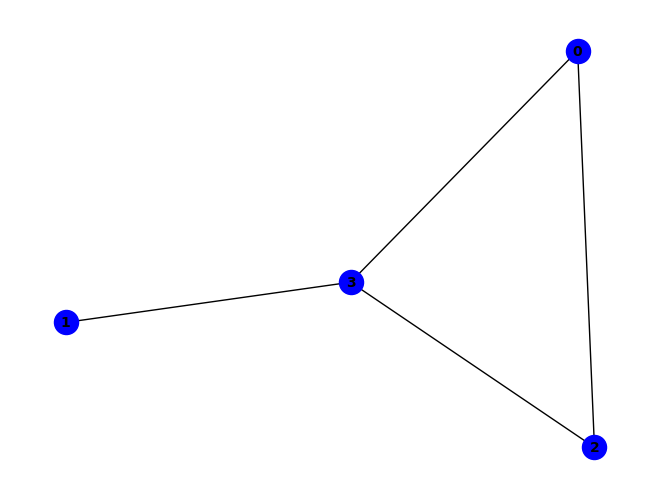

In [14]:
#choose which graph of k nodes to assign to instance

graphNumber = 2  #[0,len(graphArray)]
chosenGraph = graphGetter.chooseGraph(graphNumber)
graphGetter.printGraph()

#note that to print a specific graph you must assign it to the generator first 

Now, we must create a Boolean instance of the graph for the specific problem we wish to analyze. 
This is done by understanding that: 
- *For set-covering graph problems, like Minimum Vertex Cover, Maximum Independent Set, and Max-K Colorable, we can specify a node inclusion and exclusion via boolean bitstring representation.*

For instance, consider the graph above on four verticies for the Minimum Vertex Cover problem. We can assign each vertex a boolean variable and specify it's **exclusion** from the set-cover via negation. We can then define a function to accept a bitstring representation and give a TRUE or FALSE. So for the graph above, we can specify $x_0$,$x_1$,$x_2$,$x_3$ as the boolean variables, with $\neg{x_n}$ signifying exclusion (negation) from the set. So a cover here would be: $\neg{x_0} \land \neg{x_1} \land x_2 \land x_3$. Another one would be: $x_0 \land \neg{x_1} \land \neg{x_2} \land x_3$, or even: $x_0 \land x_1 \land x_2 \land x_3$(although it is not optimal, it is a cover).

We know that the Boolean instances for a graph G are: 
- Vertex_Cover($x_1,x_2,...,x_k$) = $\bigwedge_{x_i,x_j \in E}{(x_i \lor x_j)}$
- Independent_Set($x_1,x_2,...,x_k$) = $\bigwedge_{x_i,x_j \in E}{\neg(x_i \land x_j)}$ = $\bigwedge_{x_i,x_j \in E}{\neg{x_i}  \lor \neg{x_j}}$
And these expressions will only be true if the given labeling is a true Vertex Cover or Independent Set, respectively.

*__oracle.py__* has a class called *BooleanInstance* which will take in a networkx graph, a problem ("MIS", "MVC", "MKC") and produce a Sympy expression for it using these formulas.
.getTT() will return the minterms of where this expression is true.

We can then use the .getRM(string *polarity*) and  .produceExpression(Sympy object *expression*) function to produce our final ESOP using the easy.c++ library and *__esopTest.cpp__*

NOTE: the *polarity* argument may be "positive" or "mixed", which just determines whether to have negations in the ESOP. Mixed is usually shorter. 


In [15]:
misExpression = BooleanInstance("MVC", chosenGraph)
minterms = misExpression.getTT() #returns minterms and adds TT attribute to instance
print(minterms)

RM = misExpression.getRM("mixed")
ESOP = misExpression.produceExpression(RM)
print(ESOP)

['0011', '0111', '1001', '1011', '1101', '1110', '1111']

(a & d) ^ (c & ~a) ^ (b & c & ~d) ^ (c & ~a & ~b & ~d)


And there we have it... but are these really accurate though? Let's find out.
What I can do is take the minterms as Boolean Strings and run them through the ESOP to see if they produce a TRUE also for each. 

In [16]:
ESOPconv = str(ESOP)                                            #not currently working... gotta fix this
for minterm in minterms:
    conv = {'a':int(minterm[0]), 
            'b':int(minterm[1]), 
            'c':int(minterm[2]), 
            'd':int(minterm[3])} #adjust for different len nodes.. lazy mode 
    
    toBeXored = []
    toBeAnded = []
    i = 0
    while i < len(ESOPconv):
        if ESOPconv[i] == '(':
            i+=1
            while ESOPconv[i] != ')':
                if (ESOPconv[i].isalpha()):
                    toBeAnded.append(conv[ESOPconv[i]])
                    i+=1
                elif ESOPconv[i] == '~':
                    toBeAnded.append(((conv[ESOPconv[i + 1]]) + 1) % 2)
                    i+=2
                else: 
                    i+=1
            j = 1
            first = toBeAnded[0]
            while j < len(toBeAnded):
                first &= toBeAnded[j]
                j+=1
            toBeXored.append(first)
            toBeAnded = []
        else:
            i+=1
    l = 1
    firstX = toBeXored[0]
    while l < len(toBeXored):
        firstX ^= toBeXored[l]
        l+=1
    print(firstX)

1
1
1
1
1
1
1
